In [1]:
import cv2
import filetype
import numpy as np
import os
import h5py
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.applications import VGG16
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
input_dir = 'input'
output_dir = 'output'
data_dir = 'dataset'
model_dir = 'model'

In [3]:
images_fname = 'images.npy'
labels_fname = 'labels.npy'
model_weight_fname = 'model_weights.h5'

In [4]:
class_labels = os.listdir(input_dir)
print(class_labels)

['Tomato_Bacterial_spot', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus']


In [5]:
images_total = 0
for label in class_labels:
    total = len(os.listdir(os.path.join(input_dir, label)))
    print(label, total)
    images_total +=total
print('- = -'*10)
print('Total number of images -----',images_total)
print('- = -'*10)

Tomato_Bacterial_spot 2127
Tomato_healthy 1591
Tomato_Late_blight 1909
Tomato_Yellow_Leaf_Curl_Virus 2068
- = -- = -- = -- = -- = -- = -- = -- = -- = -- = -
Total number of images ----- 7695
- = -- = -- = -- = -- = -- = -- = -- = -- = -- = -


In [6]:
img_rows = 192
img_cols = 192
channels = 3
num_classes = len(class_labels)

In [7]:
def load_data():
    labels = os.listdir(input_dir)
    print(labels)
    total = len(labels)
    
    X = np.ndarray((images_total, img_rows, img_cols, channels), dtype = np.float32)
    y = np.zeros((images_total,), dtype = np.uint8)
    
    i = 0
    print('-'*30)
    print('Loading images...')
    print('-'*30)
    
    j = 0
    for label in labels:
        image_names = os.listdir(os.path.join(input_dir, label))
        total = len(image_names)
        print(label, total)
        for image_name in image_names:
            kind = filetype.guess(os.path.join(input_dir, label, image_name))
            if kind is None:
                print('--------------------- Cannot guess file type!')
                continue
            else:
                img = cv2.imread(os.path.join(input_dir, label, image_name), 1)
                img = np.array(cv2.resize(img, (img_rows,img_cols)))/255
                X[i] = img
                y[i] = j

            if i % 800 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1    
    print('Loading done.')
    
    y = np_utils.to_categorical(y[:images_total], num_classes)

    np.save('dataset/images.npy', X)
    np.save('dataset/labels.npy', y)

In [8]:
load_data()

['Tomato_Bacterial_spot', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus']
------------------------------
Loading images...
------------------------------
Tomato_Bacterial_spot 2127
Done: 0/2127 images
Done: 800/2127 images
Done: 1600/2127 images
Tomato_healthy 1591
Done: 2400/1591 images
Done: 3200/1591 images
Tomato_Late_blight 1909
Done: 4000/1909 images
Done: 4800/1909 images
Done: 5600/1909 images
Tomato_Yellow_Leaf_Curl_Virus 2068
Done: 6400/2068 images
Done: 7200/2068 images
Loading done.


In [9]:
X = np.load(os.path.join(data_dir,images_fname))
y = np.load(os.path.join(data_dir,labels_fname))

In [10]:
print(X.shape, y.shape)

(7695, 192, 192, 3) (7695, 4)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6540, 192, 192, 3) (6540, 4) (1155, 192, 192, 3) (1155, 4)


In [13]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_rows, channels))

In [14]:
vgg_model = Model(vgg_model.input, vgg_model.get_layer('block5_conv2').output)

In [15]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

In [16]:
model = Model(inputs=vgg_model.input, outputs=predictions)

In [17]:
for layer in vgg_model.layers:
    layer.trainable = False

In [18]:
model.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0         
__________

In [20]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1,
    validation_data=(X_test, y_test),
    shuffle=True
)

Train on 6540 samples, validate on 1155 samples
Epoch 1/1
6540/6540 [==============================] - 8287s 1s/step - loss: 0.4150 - acc: 0.8610 - val_loss: 0.1791 - val_acc: 0.9394


In [21]:
y_pred = model.predict(X_test, batch_size=32, verbose=0)

In [22]:
print(y_pred)

[[3.0303083e-02 2.4700046e-02 4.2554757e-01 5.1944935e-01]
 [9.9816304e-01 3.5044880e-04 1.4024077e-03 8.4102663e-05]
 [7.5162505e-04 3.3758517e-04 4.6955004e-02 9.5195580e-01]
 ...
 [3.5775911e-02 4.2019453e-02 8.8995999e-01 3.2244582e-02]
 [3.3669837e-03 1.4721527e-03 2.0313177e-03 9.9312955e-01]
 [7.9437804e-01 2.2420323e-02 5.7657275e-02 1.2554444e-01]]


In [23]:
y_predict = []
for i in range(0, len(y_pred)):
    y_predict.append(int(np.argmax(y_pred[i])))
len(y_predict)

1155

In [24]:
y_true = []
for i in range(0, len(y_test)):
    y_true.append(int(np.argmax(y_test[i])))
len(y_true)

1155

In [25]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

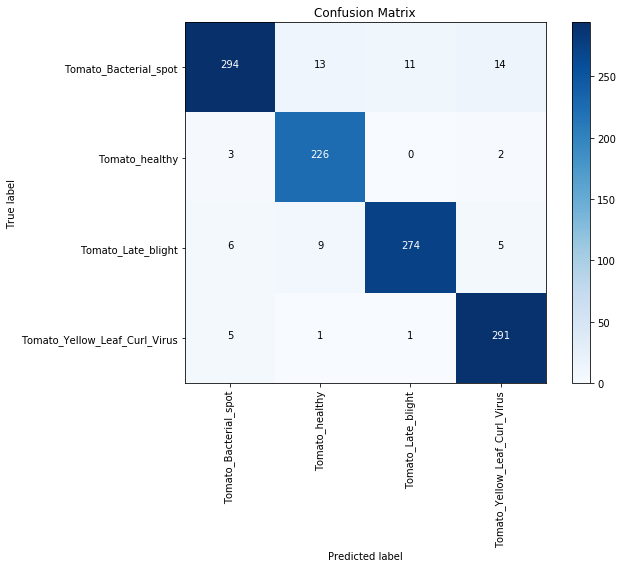

In [26]:
cm = confusion_matrix(y_true=y_true, y_pred=y_predict)
plot_confusion_matrix(cm, class_labels, title='Confusion Matrix')

In [27]:
model.save_weights(os.path.join(model_dir,model_weight_fname))

In [28]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


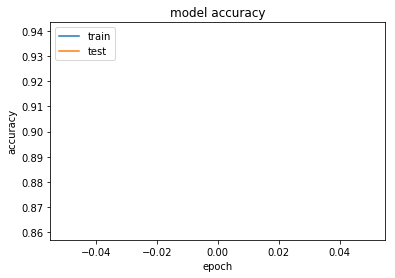

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

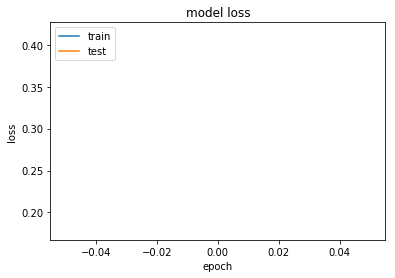

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()